In [ ]:
#https://github.com/bentrevett/pytorch-sentiment-analysis
#https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/6%20-%20Transformers%20for%20Sentiment%20Analysis.ipynb

In [1]:
pip install transformers

     |████████████████████████████████| 2.1MB 16.9MB/s 
     |████████████████████████████████| 3.3MB 54.3MB/s 
     |████████████████████████████████| 901kB 52.7MB/s 


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import time
from sklearn.metrics import classification_report
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# specify GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#df_all = pd.read_csv('all-data.csv',encoding='latin-1')
df_all = pd.read_csv('/content/drive/My Drive/content/Tweets.csv', encoding = 'latin-1' )
#df_all.columns = ["sentiment", "text"]

In [6]:
df_all.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,24/2/2015 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,24/2/2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,24/2/2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,24/2/2015 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,24/2/2015 11:14,NaN,Pacific Time (US & Canada)


In [7]:
df_all = df_all[['text','airline_sentiment']]
df_all.columns = ["text","sentiment"]
dic = {'negative' : 0, 'neutral': 1, 'positive': 2}
df_all['sentiment']= df_all['sentiment'].replace(dic).astype('int64')
df_all.head()

,text,sentiment
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [8]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df_all['text'], df_all['sentiment'], 
                                                                    random_state=45, 
                                                                    test_size=0.3, 
                                                                    stratify=df_all['sentiment'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=45, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [9]:
from transformers import AutoModel, BertTokenizerFast
# import BERT-base pretrained model
#bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [30]:
# t
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    padding='longest',
    truncation=True
)

In [31]:
## convert lists to tensors
test_seq = torch.tensor(tokens_test['input_ids'])[0+32:32+32]
test_mask = torch.tensor(tokens_test['attention_mask'])[0+32:32+32]
test_y = torch.tensor(test_labels.tolist())[0+32:32+32]

In [32]:
#define a batch size
batch_size = 32

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for test set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size, drop_last=True)

In [33]:
#import torch.nn as nn
#import torch.nn.functional as F
from torch.autograd import Variable

# reference source: https://www.programmersought.com/article/31037125394/
class AttnDPCNN(nn.Module):

    def __init__(self,batch_size,seq_len,embedding_dim,output_size_linear, 
                 cnn_channel_size, cnn_kernel_size=(3,1),cnn_padding=0, cnn_stride=1, attn_nodes_per_layer = 10):

        super(AttnDPCNN, self).__init__()
        #self.bert=bert
        self.attn_nodes_per_layer = attn_nodes_per_layer
        self.channel_size = cnn_channel_size
        self.output_size_linear = output_size_linear
        self.cnn_kernel_size = cnn_kernel_size
        self.padding = cnn_padding
        self.stride = cnn_stride
        #self.vocab_size = vocab_size
        self.embed_dim = embedding_dim
        self.seq_len = seq_len
        self.batch_size = batch_size
        
        #self.collect_out_softmax = torch.zeros(1,1).to(device)
        #self.collect_out_attn = torch.zeros(self.batch_size,self.attn_nodes_per_layer).to(device)
        
        #self.embed = nn.Embedding(self.vocab_size, self.embed_dim)
        self.conv1 = nn.Conv2d(1,  self.channel_size, (3,self.embed_dim), stride = 1) # embed_dim becomes 1
        self.conv2 = nn.Conv2d(self.channel_size,  self.channel_size,  
                                kernel_size=self.cnn_kernel_size, padding=0,
                               stride = self.stride)
        self.padding1 = nn.ZeroPad2d((0, 0, 1, 1))  # top bottom
        self.padding2 = nn.ZeroPad2d((0, 0, 0, 1))  # bottom
        self.max_pool = nn.MaxPool2d(kernel_size=(3, 1), stride=2)      
        
        self._repeat_block = nn.Sequential( # input [batch_size, num_filters, seq_len-3+1, 1]
                    nn.ZeroPad2d((0, 0, 1, 1)), # [batch_size, num_filters, seq_len, 1]
                    nn.ReLU(),
                    nn.Conv2d(self.channel_size,  self.channel_size,   # [batch_size, num_filters, seq_len-3+1, 1]
                                kernel_size=self.cnn_kernel_size, padding=0,
                               stride = self.stride),
                    nn.ZeroPad2d((0, 0, 1, 1)), # [batch_size, num_filters, seq_len, 1]
                    nn.ReLU(),
                    nn.Conv2d(self.channel_size,  self.channel_size,  # [batch_size, num_filters, seq_len-3+1, 1]
                                kernel_size=self.cnn_kernel_size, padding=0,
                               stride = self.stride),
            )
        
        self.maps = None
        # To get variying attention weights for 1) softmax output 2) 10 representing features
        self.num_repeat_blocks, self.size_repeat_blocks_list = self.dividible(2)
        self.weight_softmax_list, self.weight_attn_list = self.getWeights_init()
        
        self.counter=0
        
        # Drop probability
        self.dropout = nn.Dropout(p=0.2)
        # Last linear layer (FC)
        self.linear1 = nn.Linear(self.attn_nodes_per_layer*self.num_repeat_blocks,self.output_size_linear)
        #self.linear1 = nn.Linear(self.channel_size,self.output_size_linear)
          
    def repeat_block(self, x): # input [batch_size, num_filters, seq_len-3+1, 1]
        x = self.padding2(x) # [batch_size, num_filters, seq_len-1, 1] -> seq_len-3+1+1 = seq_len-1
        #print('padding')
        x1 = self.max_pool(x)  # [batch_size, num_filters, (seq_len-1) // 3, 1 //1] -> seq_len-3+1+1 = seq_len-1
        #print('x1',x1.shape)
        # conv block
        x2 = self._repeat_block(x1)
        #print('x2',x2.shape)
        # Identity addition
        x = x1 + x2
        #print('x1+x2',x.shape)
        # to get attn score
        #print("out softmax weights",self.weight_softmax_list[self.counter].shape)
        #out_softmax = F.linear(x.reshape(1,-1),self.weight_softmax_list[self.counter])
        
        # fix output features as 10
        out_attn = F.linear(x.reshape(x.shape[0],-1),self.weight_attn_list[self.counter])

        return x,out_attn

    def forward(self, x):
        
        self.counter =0
        #embed = self.bert(sent_id, attention_mask=mask)
        #x = embed['last_hidden_state'].unsqueeze(1) # [batch_size, 1, seq_len, embedding_dim]
        x = self.conv1(x)  # [batch_size, num_filters, seq_len-3+1, 1]
        #print(x.shape)
        x = self.padding1(x)  # [batch_size, num_filters, seq_len, 1]
        x = F.relu(x)
        x = self.conv2(x)  # [batch_size, num_filters, seq_len-3+1, 1]

        while x.size()[2] >= 2: # till seq_len is 1
            #print(x.shape)
            x,out_attn = self.repeat_block(x)  # [batch_size, num_filters,1,1] at the end
            #print(out_attn.shape) # 32 x 10
            
            if self.counter==0:
                #self.collect_out_softmax = out_softmax
                self.collect_out_attn = out_attn.unsqueeze(2)
                #self.collect_out_attn = [out_attn]
            else:
                #self.collect_out_softmax = torch.cat((self.collect_out_softmax,out_softmax),0)
                self.collect_out_attn = torch.cat((self.collect_out_attn,out_attn.unsqueeze(2)),2) 
                #self.collect_out_attn.append(out_attn)
        
            self.counter +=1


        ## CALCULATION OF DOT PRODUCT ATTENTION ##
        #print("collect out attn",self.collect_out_attn.shape) # 32 x 10 x 5
        final_collect_out_attn = torch.zeros_like(self.collect_out_attn)
        key = self.collect_out_attn.clone() # 32 x 10 x 5
        value = self.collect_out_attn.clone() # 32 x 10 x 5
        for i in range(self.counter):

            #start = i*self.attn_nodes_per_layer
            #end = start+self.attn_nodes_per_layer
            query = self.collect_out_attn[:,:,i].clone().unsqueeze(2) # 32 x 10 x 1

            # dot product and then softmax
            in_softmax = torch.bmm(key.transpose(1,2),query)/self.num_repeat_blocks
            #print("in softmax",in_softmax.shape) #32 x 5 x 1
            #print("in soft scores sum",in_softmax[0,:,0])
            prob = F.softmax(in_softmax,1)
            #print("prob",prob.shape) #32x 5 x 1
            #print("prob sum",prob[0,:,0])
            
            final_vec = torch.bmm(value,prob) # 32 x 10 x 1
            #print("final_vec",final_vec.shape)

            if i==0:
              output = final_vec
              maps = prob.detach().cpu()
            else:
              output = torch.cat((output,final_vec),2)
              maps = torch.cat((maps,prob.detach().cpu()),2)
        
        #output =  output/self.num_repeat_blocks
        #print("output",output.shape) # 32 x 10 x 5



        ## FULLY CONNECTED ##
        # linear layer
        output = self.linear1(output.reshape(x.shape[0],-1))  # [batch_size, output size]
        output = self.dropout(output)
        return output, maps
    
    def dividible(self,p):
        n=self.seq_len
        i = 0
        out=[]
        while n>=p:
            if i==0:
                n = (n-2)//2
               #n=n-2
               #out.append(n-1)
            else:
                n = n//2
                #out.append(n)
            i += 1
            out.append(n)
        return i,out
    
    def getWeights_init(self):
        weights_softmax_list = []
        weights_attn_list = []
        for i in range(self.num_repeat_blocks):
            # size_repeat_blocks_list contains various seq length
            #print('batch size', self.batch_size)
            #print('seq len', self.size_repeat_blocks_list[i])
            #print('channel size', self.channel_size)
            weights_softmax_list.append(Variable(torch.randn(1,self.batch_size*1*self.size_repeat_blocks_list[i]*self.channel_size)).to(device))
            weights_attn_list.append(Variable(torch.randn(self.attn_nodes_per_layer,1*self.size_repeat_blocks_list[i]*self.channel_size)).to(device)) # fix output features as 10
        return weights_softmax_list,weights_attn_list
  

In [34]:
import pickle
filenamedpcnn = '/content/drive/My Drive/content/BertAttnDPCNN5_colab_attention_False_Tweet_Exp6DPCNN.pkl'
filenamebert = '/content/drive/My Drive/content/BertAttnDPCNN5_colab_attention_False_Tweet_Exp6BERT.pkl'

bert = pickle.load(open(filenamebert, 'rb'))
dpcnn = pickle.load(open(filenamedpcnn, 'rb'))


In [35]:
#dpcnn = AttnDPCNN(32,40,768, 3, 128) # batchsize, seq len, embed dim, classes, no of filters
dpcnn = dpcnn.to(device)
bert = bert.to(device)

TEST

In [36]:
# function for evaluating the model
def test():
  
  print("\nEvaluating...")
  t0 = time.time()
  # deactivate dropout layers
  #model.eval() replace below?

  #load weights of best model
  #bpath = 'bert_saved_weights.pt'
  #bert.load_state_dict(bert.load(bpath))

  bert.eval()
  dpcnn.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []
  total_targets = []
  maps_list=[]
  # iterate over batches
  for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = time.time() - t0
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      embed = bert(sent_id, attention_mask=mask)
      x = embed['last_hidden_state'].unsqueeze(1) # [batch_size, 1, seq_len, embedding_dim]
      preds,maps = dpcnn(x)
      maps_list.append(maps)
      # compute the validation loss between actual and predicted values
      #loss = cross_entropy(preds,labels)

      #total_loss = total_loss + loss.item()

      preds = preds.detach().cpu()
      labels = labels.detach().cpu()

      total_preds.append(preds.numpy())
      total_targets.append(labels.numpy())
  # compute the validation loss of the epoch
  #avg_loss = total_loss / len(test_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  total_targets = np.concatenate(total_targets, axis=0)
  dpcnn.maps = maps_list
  return total_preds, total_targets

In [37]:
test_preds, test_targets = test()



Evaluating...


In [38]:
test_preds2 = test_preds.argmax(axis=1)
test_preds2.shape

(32,)

In [39]:
test_targets.shape

(32,)

In [40]:
correct = []
wrong = []
for i,(target,pred) in enumerate(zip(test_targets,test_preds2)):
  if target == pred:
    correct.append(i)
  else:
    wrong.append(i)


In [41]:
print(len(correct))
print(len(wrong))
print(len(dpcnn.maps))

28
4
1


In [42]:
dpcnn.maps[0].shape


torch.Size([32, 4, 4])

In [43]:
correct[0:5]

[0, 1, 3, 4, 5]

In [44]:
wrong

[2, 17, 21, 28]

In [45]:
df1=test_labels.reset_index()
df2=test_text.reset_index()

Visualization of incorrect prediction with attention map - 1st example

In [46]:
print(df1['sentiment'][2])
print(df2['text'][2])

0
@united have since dropped to 2 layovers but still not acceptable.


In [47]:
maps = dpcnn.maps[0]
map = maps[2,:,:]

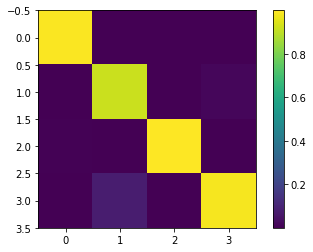

In [48]:
import matplotlib.pyplot as plt
plt.imshow(map)
plt.colorbar()
plt.show()

Visualization of incorrect prediction with attention map - 2nd example

In [57]:
print(df1['sentiment'][17])
print(df2['text'][17])

0
@USAirways AND my rebooked flt isn't until Monday??  AND I don't get a voucher for a hotel?!  Never again, US airways.


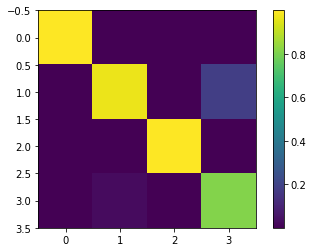

In [56]:
maps = dpcnn.maps[0]
map = maps[17,:,:]
plt.imshow(map)
plt.colorbar()
plt.show()

Visualization of incorrect prediction with attention map - 3rd example

2
@united would love help getting there today. In #EWR now. Will take any airline and connections. Thx


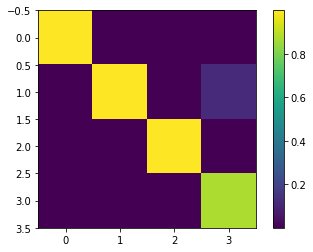

In [58]:
print(df1['sentiment'][21])
print(df2['text'][21])
maps = dpcnn.maps[0]
map = maps[21,:,:]
plt.imshow(map)
plt.colorbar()
plt.show()

Visualization of incorrect prediction with attention map - 4th example

2
@AmericanAir @dfwairport Guys, let it go. http://t.co/vOxcghciJi


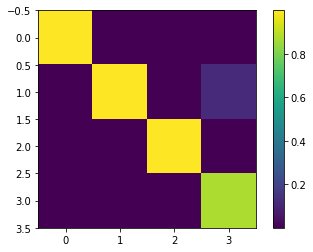

In [59]:
print(df1['sentiment'][28])
print(df2['text'][28])
maps = dpcnn.maps[0]
map = maps[21,:,:]
plt.imshow(map)
plt.colorbar()
plt.show()

Visualization of correct prediction with attention map

In [ ]:
print(df1['sentiment'][0])
print(df2['text'][0])

2
The transaction doubles Tecnomens workforse , and adds a fourth to their net sales .


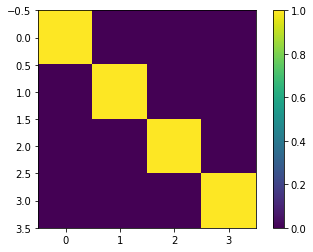

In [51]:
maps = dpcnn.maps[0]
map = maps[0,:,:]
plt.imshow(map)
plt.colorbar()
plt.show()

Visualization of features and classes

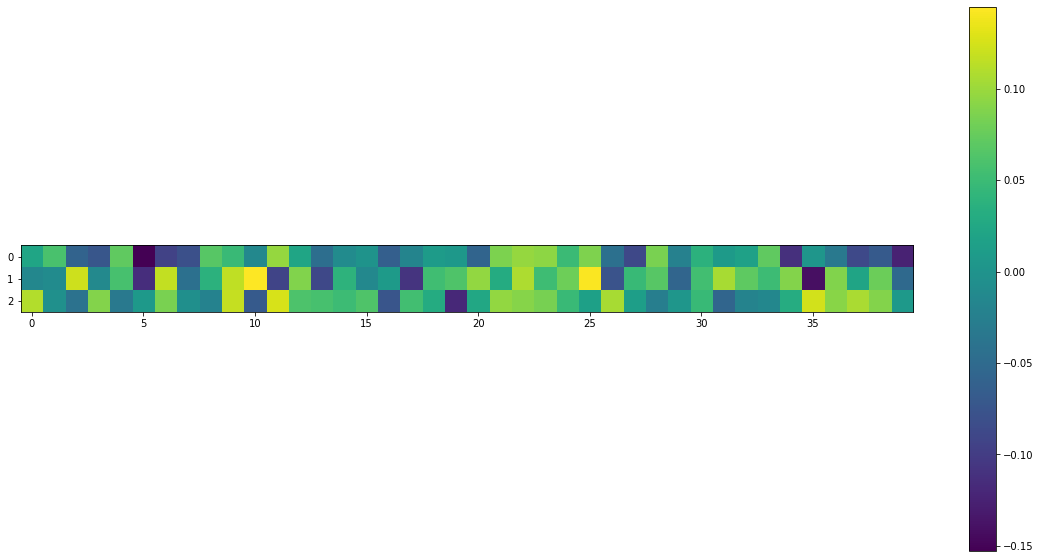

In [52]:
import matplotlib.pyplot as plt
map = dpcnn.linear1.weight.detach().cpu().numpy()
plt.figure(figsize=(20,10))
plt.imshow(map)
plt.colorbar()
plt.show()